In [54]:
# Imports
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nn import (nn, io, preprocess)

In [55]:
# open text file 
text_rap1 = io.read_text_file("data/rap1-lieb-positives.txt")
# print(len(text_rap1))
io.read_text_file("data/rap1-lieb-positives.txt")

# assign labels to rap1-lieb positives 
positive_rap1_dict = {i:1 for i in text_rap1}

In [56]:
# open fasta file
fasta = io.read_fasta_file("data/yeast-upstream-1k-negative.fa")
io.read_fasta_file("data/yeast-upstream-1k-negative.fa")

# get first part of each sequence 
fasta_short = [i[0:17] for i in fasta]

# assign labels to rap1-lieb negatives
negative_rap1_dict = {i:0 for i in fasta_short}

### Sampling scheme
- Equal negative and positive sequences were input to prevent class imbalance from affecting training 
- Subsets of both the negative and positive sequences were chosen randomly with replacement to reduce bias

In [57]:
# preprocess sequences and labels
seqs = [*positive_rap1_dict.keys()] + [*negative_rap1_dict.keys()]
labels = [*positive_rap1_dict.values()] +[*negative_rap1_dict.values()]

# perform preprocessing on sequences and labels
seqs_processed, labels_processed = preprocess.sample_seqs(seqs,labels)

# turn processed data into arrays and check shapes 
seqs_processed = np.array(seqs_processed)
labels_processed = np.array(labels_processed)
print(seqs_processed.shape , labels_processed.shape)

(274,) (274,)


In [58]:
# one hot encode sequences
seqs_processed = preprocess.one_hot_encode_seqs(seqs_processed)

# check shape of input matrices 
print("seqs shapes", seqs_processed.shape)
print("label shapes", labels_processed.shape)

seqs shapes (274, 68)
label shapes (274,)


In [59]:
# Split the data into training and validation sets
X_train, X_val, y_val, y_train = train_test_split(seqs_processed, labels_processed, test_size=0.2, random_state=42)

print("training dataset dimensions:", X_train.shape)
print("training validation dataset dimensions", X_val.shape)
print("test dataset dimensions", y_train.shape)
print("test validation dimensions", y_val.shape) 

training dataset dimensions: (219, 68)
training validation dataset dimensions (55, 68)
test dataset dimensions (55,)
test validation dimensions (219,)


In [60]:
# Define the architecture of the neural network
nn_architecture = [
    {'input_dim': np.shape(X_val)[1], 'output_dim': 100, 'activation': 'sigmoid'},
    {'input_dim': 100, 'output_dim': np.shape(X_val)[1], 'activation': 'sigmoid'}
]

In [61]:
# Initialize the Neural Network
nn_DNA = nn.NeuralNetwork(
    nn_arch=nn_architecture,
    lr=25, # tried 10, 20, 30
    seed=42,
    batch_size=np.shape(X_train)[0],
    epochs=1250, # tried 1000, 2000
    loss_function='_binary_cross_entropy'
)

In [62]:
# check shapes of inputs of NN
L_params = [X_train, X_train.T, X_val, X_val.T]
for index, i in enumerate(L_params):
    print(index, i.shape)

0 (219, 68)
1 (68, 219)
2 (55, 68)
3 (68, 55)


In [63]:
# Train the Neural Network
loss_train, loss_val = nn_DNA.fit(X_train, X_train.T, X_val, X_val.T)

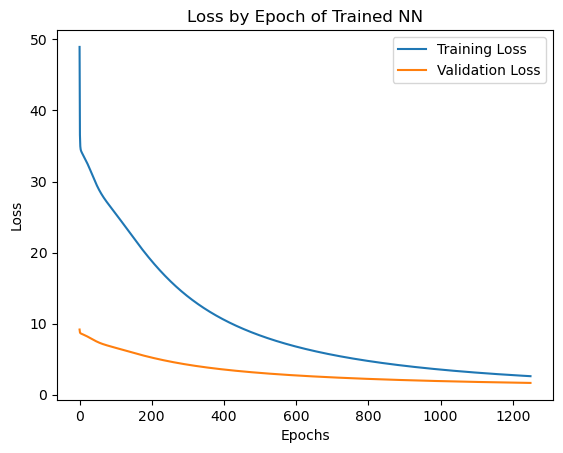

In [64]:
# Plot the training and validation loss
plt.title("Loss by Epoch of Trained NN")
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
# Make predictions on the validation set
y_val_pred = nn_DNA.predict(X_val)

In [66]:
# reconstruction error of trained model
delta_pred = y_val_pred - X_val
error = np.absolute(np.sum(delta_pred,axis = 1 ))
avg_error = np.mean(error)
print("error of trained classifier:", avg_error)  # MSE error: 1.6939752738993865

error of trained classifier: 0.8413392603018514


### Loss function
Since the model is a binary classifier, binary cross entropy is appropriate. Testing the models with both binary cross entropy and mean squared error showed that binary cross entropy performed better (near 1.5 for MSE, near 0.9 for BCE). 
### Hyperparameters
- Initial hyperparameters were chosen from the autoencoder portion 
- Batch size was kept at the size of the input since the dimensions of the input will not cause memory issues
- Sigmoid activation was chosen as relu may cause overflow errors with a high learning rate
- Number of nodes in hidden layer was initially chosen arbitrarily
- Hyperparameters were further optimized by a grid search strategy. Learning rate was increased since decay was slow across 1000 epochs. Number of epochs was also increased. 
- Model was overtuned at 2000 epochs and a learning rate of 30 (training loss went below validation loss, high reconstruction error). This also significantly increased the runtime (6m 32s on macbook pro)
- With these data in mind, I chose 1250 epochs and a learning rate of 25